In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors


%matplotlib inline

In [2]:
from copy import deepcopy

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate, find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

# Read processed data

In [27]:
df = pd.read_csv("../Data/NHANES_telomere.csv")

df.head()

,Telomean,HoursWorked,Gender,Age,Race,Education,MaritalStatus,HouseholdIncome
0,0.389337,>=41,Female,<=18,Hispanic,< GED,Single,20k-45k
1,0.389337,21-40,Female,31-50,Other,College,Married,20k-45k
2,0.433244,>=41,Male,>=70,White,GED,Married,<20k
3,0.433244,21-40,Male,31-50,White,College,Married,45k-75k
4,0.443293,>=41,Female,31-50,Other,College,Married,>=75k


In [28]:
hours_worked_map = {
    "<=20": 1,
    "21-40": 2,
    ">=41": 3
}

gender_map = {
    "Female": 1,
    "Male": 2
}

age_map = {
    "<=18": 1,
    "19-30": 2,
    "31-50": 3,
    "51-70": 4,
    ">=70": 5
}

race_map = {
    "White": 1,
    "Black": 2,
    "Hispanic": 3,
    "Other": 3
}

education_map = {
    "< GED": 1,
    "GED": 2,
    "College": 3
}

marital_status_map = {
    "Single": 1,
    "Married": 2,
    "Divorced/Widowed": 3
}

income_map = {
    "<20k": 1,
    "20k-45k": 2,
    "45k-75k": 3,
    ">=75k": 4
}


df["HoursWorked"] = df["HoursWorked"].map(hours_worked_map)
df["Gender"] = df["Gender"].map(gender_map)
df["Age"] = df["Age"].map(age_map)
df["Race"] = df["Race"].map(race_map)
df["Education"] = df["Education"].map(education_map)
df["MaritalStatus"] = df["MaritalStatus"].map(marital_status_map)
df["HouseholdIncome"] = df["HouseholdIncome"].map(income_map)

df.head()

,Telomean,HoursWorked,Gender,Age,Race,Education,MaritalStatus,HouseholdIncome
0,0.389337,3,1,1,3,1,1,2
1,0.389337,2,1,3,3,3,2,2
2,0.433244,3,2,5,1,2,2,1
3,0.433244,2,2,3,1,3,2,3
4,0.443293,3,1,3,3,3,2,4


In [29]:
df["Race"].value_counts()

Race
1    2034
3    1805
2    1039
Name: count, dtype: int64

In [30]:
Z = df.to_numpy()
X = Z[:, [1, 2, 3, 5]]
y = Z[:, 0]
# y = (y - np.min(y)) / (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

num_data = X.shape[0]
print(f"There are {num_data} data points")

There are 4878 data points


In [31]:
y[:10]

array([[0.38933653],
       [0.38933653],
       [0.43324358],
       [0.43324358],
       [0.44329284],
       [0.44329284],
       [0.45303596],
       [0.45303596],
       [0.46510527],
       [0.46510527]])

In [32]:
np.unique(X[:, 3])

array([1., 2., 3.])

# Analysis

In [33]:
M = 4
R = np.array([4, 3, 6, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

In [34]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])


# policy_means = loss.compute_policy_means(D, y, num_policies)



# true_best_eff = np.max(mu_policies)
# print(true_best_eff)
# np.where(mu_policies == true_best_eff)

In [181]:
race_profiles = np.unique(Z[:, 4])

all_active_profile = tuple([1] * M)

policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == all_active_profile]
unzipped_temp = list(zip(*policies_temp))
policy_race_idx = list(unzipped_temp[0])
policy_race = list(unzipped_temp[1])


D_race = {}
X_race = {}
y_race = {}
policy_means_race = {}
mu_policies_race = {}
true_best_eff_race = {}
policy_means = np.zeros(shape=(len(policy_race), 2))
for race in race_profiles:
    idx = np.where(Z[:, 4] == race)
    X_race[race] = X[idx, :][0]
    y_race[race] = y[idx, :][0]
    num_data_race = X_race[race].shape[0]
    
    D_race[race] = np.zeros(shape=y_race[race].shape, dtype=np.int64)
    for i in range(num_data_race):
        policy_i = tuple([int(x) for x in X_race[race][i, :]])
        policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
        D_race[race][i, 0] = int(policy_idx[0])
    
    range_list = list(np.arange(len(policy_profiles_idx_k)))
    policy_map = {i: x for i, x in zip(policy_profiles_idx_k, range_list)}
    D_race[race] = np.vectorize(policy_map.get)(D_race[race])


    policy_means_race[race] = loss.compute_policy_means(D_race[race], y_race[race], len(policy_race))
    
    nodata_idx = np.where(policy_means_race[race][:, 1] == 0)[0]
    policy_means_race[race][nodata_idx, 0] = -np.inf
    policy_means_race[race][nodata_idx, 1] = 1
    mu_policies_race[race] = policy_means_race[race][:, 0] / policy_means_race[race][:, 1]
    policy_means_race[race][nodata_idx, 1] = 0

    policy_means_race[race][nodata_idx, 0] = 0
    policy_means += policy_means_race[race]
    policy_means_race[race][nodata_idx, 0] = -np.inf

    true_best_eff_race[race] = np.max(mu_policies_race[race])
    # print(true_best_eff, np.where(mu_policies_race[race] == true_best_eff_race[race]))

nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]
policy_means[nodata_idx, 1] = 0

true_best_eff = np.max(mu_policies)
# print(true_best_eff, np.where(mu_policies == true_best_eff))

In [36]:
D_remapped = D.copy()
range_list = list(np.arange(len(policy_race_idx)))
policy_map = {i: x for i, x in zip(policy_race_idx, range_list)}
D_remapped = np.vectorize(policy_map.get)(D_remapped)

In [331]:
policy_race_idx_full = {}
for k, race in enumerate(race_profiles):
    policy_race_idx_full[k] = (k*len(range_list) + np.array(range_list)).tolist()

In [313]:
policy_means_race_full = np.concatenate((policy_means_race[1], policy_means_race[2], policy_means_race[3]), axis=0)

In [230]:
H = 40

# # This is too restrictive
# reg = 1e-2

reg = 1e-4
theta = 0.12

In [231]:
# In the best case, every other profile becomes a single pool
# So max number of pools per profile is adjusted accordingly
# H_profile = H - num_profiles + 1
unordered_factors = race_profiles
num_unordered_factors = len(unordered_factors)
H_profile = H - num_unordered_factors + 1

# Subset data by profiles and find equiv policy lower bound
D_profiles = {}
y_profiles = {}
policies_profiles = {}
policy_means_profiles = {}
eq_lb_profiles = np.zeros(shape=(num_unordered_factors,))
for k, profile in enumerate(unordered_factors):

    policy_profiles_idx_k = policy_race_idx
    policies_profiles[k] = policy_race

    D_k = D_race[profile]
    # range_list = list(np.arange(len(policy_profiles_idx_k)))
    # policy_map = {i: x for i, x in zip(policy_profiles_idx_k, range_list)}
    # D_k = np.vectorize(policy_map.get)(D_k)
    y_k = y_race[profile]
    D_profiles[k] = D_k
    y_profiles[k] = y_k

    if D_k is None:
        policy_means_profiles[k] = None
        eq_lb_profiles[k] = 0
        H_profile += 1
    else:
        policy_means_k = policy_means_race[profile]
        policy_means_profiles[k] = policy_means_k
        eq_lb_profiles[k] = find_profile_lower_bound(D_k, y_k, policy_means_k)

eq_lb_profiles /= num_data
eq_lb_sum = np.sum(eq_lb_profiles)
print(eq_lb_profiles, eq_lb_sum)

# # Now solve each profile independently
# # This step can be parallelized
rashomon_profiles: list[RashomonSet] = [None]*num_unordered_factors
feasible = True
for k, profile in enumerate(unordered_factors):
    theta_k = theta - (eq_lb_sum - eq_lb_profiles[k])
    print(theta_k)
    D_k = D_profiles[k]
    y_k = y_profiles[k]

    policies_k = policies_profiles[k]
    policy_means_k = policy_means_profiles[k]
    profile_mask = list(map(bool, all_active_profile))
    # print(profile_mask)

    # # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    # R_k = R[profile_mask]
    # M_k = np.sum(profile)
    R_k = R
    M_k = M
    # print(len(policies_k), policy_means_k.shape)

    if D_k is None:
        # TODO: Put all possible sigma matrices here and set loss to 0
        rashomon_profiles[k] = RashomonSet(shape=None)
        rashomon_profiles[k].P_qe = [None]
        rashomon_profiles[k].Q = np.array([0])
        continue

    # Control group is just one policy
    if M_k == 0:
        rashomon_k = RashomonSet(shape=None)
        control_loss = eq_lb_profiles[k] + reg
        rashomon_k.P_qe = [None]
        rashomon_k.Q = np.array([control_loss])
    else:
        rashomon_k = RAggregate_profile(M_k, R_k, H_profile, D_k, y_k, theta_k, all_active_profile, reg,
                                        policies_k, policy_means_k, normalize=num_data)
        rashomon_k.calculate_loss(D_k, y_k, policies_k, policy_means_k, reg, normalize=num_data)

    rashomon_k.sort()
    rashomon_profiles[k] = rashomon_k
    if len(rashomon_k) == 0:
        feasible = False
        print(f"No Rashomon set for race profile {profile}")
        break
    else:
        print(f"Race: {profile}. Found {len(rashomon_profiles[k])} partitions")
        

# Combine solutions in a feasible way
if feasible:
    R_set = find_feasible_combinations(rashomon_profiles, theta, H, sorted=True)
else:
    R_set = []
if len(R_set) > 0:
    rashomon_profiles = remove_unused_poolings(R_set, rashomon_profiles)

print(len(R_set))

[0.02779096 0.01150266 0.032491  ] 0.07178462221034794
0.07600633757265733
Race: 1.0. Found 476 partitions
0.0597180362966581
Race: 2.0. Found 476 partitions
0.08070638170998867
Race: 3.0. Found 476 partitions
44060452


In [232]:
for k, profile in enumerate(race_profiles):
    print(f"Race: {profile}. Found {len(rashomon_profiles[k])} partitions")

Race: 1.0. Found 476 partitions
Race: 2.0. Found 476 partitions
Race: 3.0. Found 476 partitions


In [233]:
rashomon_homogeneous = RAggregate_profile(M, R, H, D_remapped, y, theta, all_active_profile, reg,
                                          policy_race, policy_means, normalize=num_data)
rashomon_homogeneous.calculate_loss(D_remapped, y, policy_race, policy_means, reg, normalize=num_data)

print(len(rashomon_homogeneous))

480


In [234]:
R_set_pruned = []

for r in R_set:
    current_sigma = None
    # homoegeneous = False
    homoegeneous = True
    for race in race_profiles:
        race = int(race) - 1
        sigma_id = r[race]
        sigma_race = rashomon_profiles[race].sigma[sigma_id]
        if current_sigma is None:
            current_sigma = sigma_race
        elif not np.array_equal(current_sigma, sigma_race):
            homoegeneous = False
            break
    
    if homoegeneous:
        found_in_homogeneous = False
        for idx, r_sigma in enumerate(rashomon_homogeneous.sigma):
            if np.array_equal(r_sigma, current_sigma):
                found_in_homogeneous = True
                R_set_pruned.append([-1, idx])
                break
        if not found_in_homogeneous:
            print("Not found :(")
    else:
        R_set_pruned.append(r)

print(len(R_set_pruned))

44060452


In [245]:
# import pickle

# full_rashomon_data = {
#     "R_set_pruned": R_set_pruned,
#     "rashomon_profiles": rashomon_profiles,
#     "rashomon_homogeneous": rashomon_homogeneous
# }

# with open("../Results/nhanes_r_set.pkl", "wb") as f:
#     pickle.dump(full_rashomon_data, f, pickle.HIGHEST_PROTOCOL)

In [246]:
import pickle


with open("../Results/nhanes_r_set.pkl", "rb") as f:
    full_rashomon_data = pickle.load(f)#, pickle.HIGHEST_PROTOCOL)

R_set_pruned = full_rashomon_data["R_set_pruned"]
rashomon_profiles = full_rashomon_data["rashomon_profiles"]
rashomon_homogeneous = full_rashomon_data["rashomon_homogeneous"]

# full_rashomon_data = {
#     "R_set_pruned": R_set_pruned,
#     "rashomon_profiles": rashomon_profiles,
#     "rashomon_homogeneous": rashomon_homogeneous
# }

In [235]:
model_losses = []
model_sizes = []

for i, r in enumerate(R_set_pruned):
    if r[0] == -1:
        model_i = r[1]
        loss_i = rashomon_homogeneous.loss[model_i]
        size_i = rashomon_homogeneous.pools[model_i]
    else:
        model_i = r
        loss_i = 0
        size_i = 0
        for race, race_model in enumerate(model_i):
            loss_i += rashomon_profiles[race].loss[race_model]
            size_i += rashomon_profiles[race].pools[race_model]
    model_losses.append(loss_i)
    model_sizes.append(size_i)

model_losses = np.array(model_losses)
model_sizes = np.array(model_sizes)
model_mses = model_losses - reg * model_sizes

best_loss = np.min(model_losses)
worst_loss = np.max(model_losses)

eps = (worst_loss - best_loss) / best_loss
print(f"Best loss = {best_loss}, Worst loss = {worst_loss}, epsilon = {eps}")

Best loss = 0.0762939584741501, Worst loss = 0.08340080604943513, epsilon = 0.09315085646909994


In [236]:
model_post_prob = np.exp(-model_losses)
model_post_prob = model_post_prob - np.min(model_post_prob)
model_post_prob = model_post_prob / np.max(model_post_prob)

# Plots

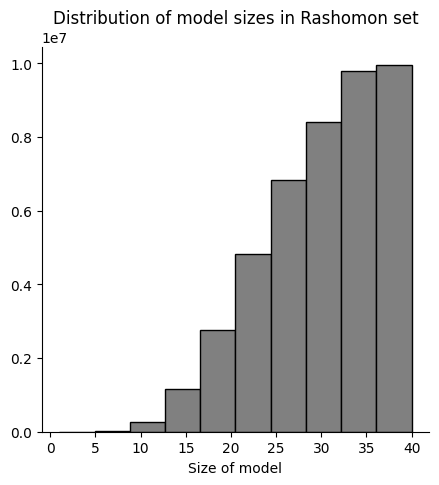

In [251]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes,
        color="grey", edgecolor="black")

# ax.set_xlim(1, H)
ax.set_xlabel("Size of model")
ax.set_ylabel("")
ax.set_title("Distribution of model sizes in Rashomon set")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("../Figures/nhanes/rset_size_dist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

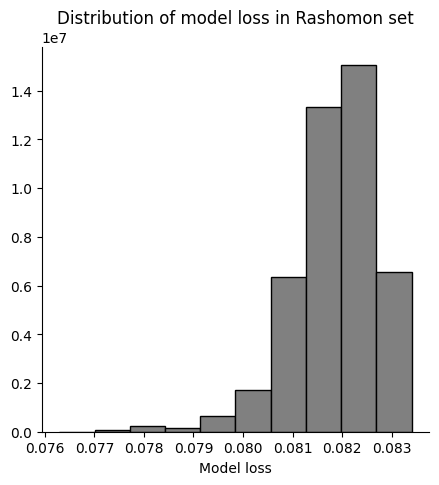

In [252]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_losses,
        color="grey", edgecolor="black")

# ax.set_xlim(1, H)
ax.set_xlabel("Model loss")
ax.set_ylabel("")
ax.set_title("Distribution of model loss in Rashomon set")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("../Figures/nhanes/rset_loss_dist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

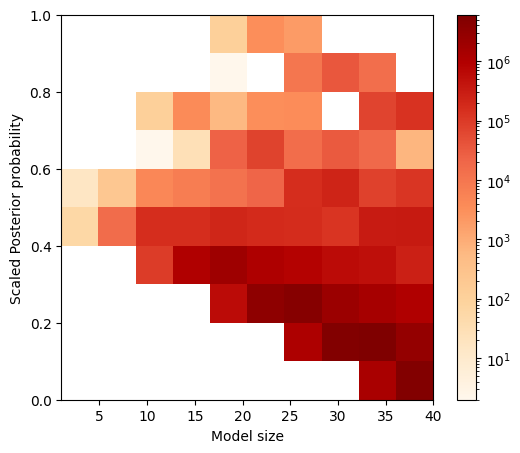

In [253]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes, model_post_prob, norm=colors.LogNorm(),
             cmap="OrRd")
fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)

ax.set_xlabel("Model size")
ax.set_ylabel("Scaled Posterior probability")


plt.savefig("../Figures/nhanes/rset_2d_hist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_2d_hist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

## Upper left of the histogram

In [375]:
scaled_prob_threshold = 0.5
model_size_threshold = 30

# model_sizes_2 = model_sizes.copy()
# model_post_prob_2 = model_post_prob.copy()

# model_sizes_2[model_sizes_2 > model_size_threshold] = -1
# model_post_prob_2[model_post_prob_2 > scaled_prob_threshold] = -1

R_set_2 = []
model_sizes_2 = []
model_losses_2 = []
model_pools_2 = []
model_pool_means_2 = []
for idx, r_set in enumerate(R_set_pruned):
    
    if model_sizes[idx] > model_size_threshold or model_post_prob[idx] < scaled_prob_threshold:
        continue

    if r_set[0] != -1:
        pi_policies_profiles_r = {}
        for race, model_race in enumerate(r_set):
            sigma_r_prof = rashomon_profiles[race].sigma[model_race]
            _, pi_policies_r_k = extract_pools.extract_pools(policy_race, sigma_r_prof)
            pi_policies_profiles_r[race] = pi_policies_r_k
    
        pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policy_race_idx_full)
        pool_means_r = loss.compute_pool_means(policy_means_race_full, pi_pools_r)

    else:
        sigma_r = rashomon_homogeneous.sigma[r_set[1]]
        pi_pools_r, pi_policies_r = extract_pools.extract_pools(policy_race, sigma_r)
        pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
        # TODO: Check whether the policy ids are correctly mapped
        # If not, map them here instead of when estimating effects


    R_set_2.append(r_set)
    model_sizes_2.append(model_sizes[idx])
    model_losses_2.append(model_losses[idx])
    model_pools_2.append(pi_pools_r)
    model_pool_means_2.append(pool_means_r)


model_sizes_2 = np.array(model_sizes_2)
model_losses_2 = np.array(model_losses_2)
model_mses_2 = model_losses_2 - reg * model_sizes_2
model_post_prob_2 = np.exp(-model_losses_2)
model_scaled_post_prob_2 = model_post_prob_2 - np.min(model_post_prob_2)
model_scaled_post_prob_2 = model_scaled_post_prob_2 / np.max(model_scaled_post_prob_2)

KeyboardInterrupt: 

### Estimating effects

In [365]:
all_policies_race = []
for race in race_profiles:
    for pol in policy_race:
        pol = tuple([x for x in pol] + [int(race)])
        all_policies_race.append(pol)

In [366]:
policies_present = np.sort(np.unique(D_remapped))

beta = np.zeros(270)


for i, model in enumerate(R_set_2):

    beta_i = np.zeros(270)
    pool_means_i = model_pool_means_2[i]

    # Do some calculation
    for pool_id in range(len(pool_means_i)):
        for policy in model_pools_2[i][pool_id]:
            beta_i[policy] = pool_means_i[pool_id]
            if r_set[0] == -1:
                beta_i[policy+90] = pool_means_i[pool_id]
                beta_i[policy+180] = pool_means_i[pool_id]

    beta += beta_i * model_post_prob_2[i]

beta /= np.sum(model_post_prob_2)

beta_subset = beta

beta_subset_sorted = list(np.sort(beta_subset))

policy_id_1 = np.where(beta == beta_subset_sorted[-1])[0][0]
policy_id_2 = np.where(beta == beta_subset_sorted[-2])[0][0]
policy_id_3 = np.where(beta == beta_subset_sorted[-3])[0][0]
policy_id_4 = np.where(beta == beta_subset_sorted[-4])[0][0]
policy_id_worst = np.where(beta == beta_subset_sorted[0])[0][0]

print(f"Best \t\t {all_policies_race[policy_id_1]} \t{beta_subset_sorted[-1]}")
print(f"Second Best \t {all_policies_race[policy_id_2]} \t{beta_subset_sorted[-2]}")
print(f"Third Best \t {all_policies_race[policy_id_3]} \t{beta_subset_sorted[-3]}")
print(f"Fourth Best \t {all_policies_race[policy_id_4]} \t{beta_subset_sorted[-4]}")
print(f"Worst \t\t {all_policies_race[policy_id_worst]} \t{beta_subset_sorted[0]}")

Best 		 (1, 1, 4, 1, 3) 	2.0706196769939593
Second Best 	 (1, 1, 4, 2, 3) 	1.628191960446471
Third Best 	 (1, 1, 5, 1, 3) 	1.4897665450871092
Fourth Best 	 (1, 1, 4, 3, 3) 	1.4134795366012074
Worst 		 (1, 2, 5, 3, 3) 	0.7868106264186314


[0.7868106264186314,
 0.8818437441162388,
 0.9351404391221899,
 0.9390126479448234,
 0.9461458676500983,
 0.9464743281605793,
 0.9483154779620294,
 0.9511553926870843,
 0.966581394083498,
 0.9678011246352429,
 0.9685041553978361,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.969610424358927,
 0.9696104